In [1]:
from scipy import fftpack
from scipy import signal

import scipy.io.wavfile  # WAV 유형 오디오 파일
from scipy import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

## 스펙트럼 분석
시간 영역 신호를 주파수 영역으로 변환
### 푸리에 변환
**푸리에 변환:** ![F](F.jpg)  
**역푸리에 변환:** ![I](I.jpg)  
**이산 푸리에 변환(DFT):** ![D](D.jpg)  
연속인 프로세스에 DFT를 사용하려면 표본 추출을 통해 신호를 이산값으로 줄여야 함  
**샘플링 이론:** 대역폭 B를 가진 연속 신호는 샘플링 주파수 f_x >= 2B인 이산 표본으로부터 재구성할 수 있음

In [2]:
# 신호의 잡음 표본을 생성하는 함수
def signal_samples(t):
  return (2 * np.sin(2 * np.pi + t) + 3 * np.sin(22 * 2 * np.pi * t) + 2 * np.random.randn(*np.shape(t)))

In [3]:
B = 30.0  # 주파수 스펙트럼
f_s = 2 * B  # 샘플링 주파수
delta_f = 0.01  # 분해능
N = int(f_s / delta_f); N  # 표본 개수

6000

In [4]:
T = N / f_s; T  # 표본주기

100.0

In [5]:
t = np.linspace(0, T, N)  # 표본 추출 시간 배열 생성
f_t = signal_samples(t)   # 신호의 잡음 표본 생성

Text(0.5, 0, 'time (s)')

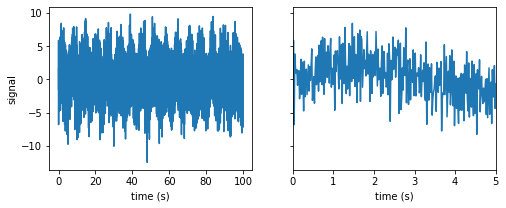

In [6]:
# 다소 잡음이 있으며 추가된 랜덤 잡음은 대부분 순수 사인 신호
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)                                                                       
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")

In [7]:
F = fftpack.fft(f_t)  # fft함수를 이산 표본 배열에 적용하여 DFT 계산
f = fftpack.fftfreq(N, 1.0/f_s)  # 각 주파수 빈에 해당하는 주파수 계산

In [8]:
mask = np.where(f >= 0)  # 양의 주파수 성분을 선택하기 위해 마스크 생성

Text(0, 0.5, '$\\log(|F|)$')

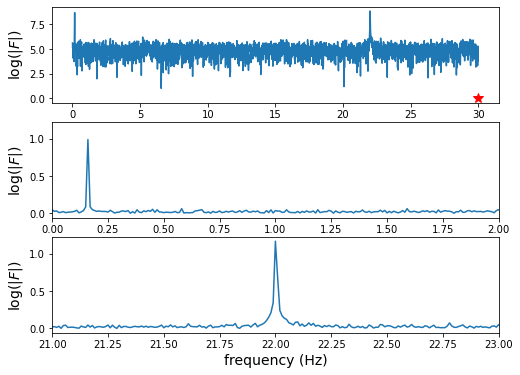

In [9]:
# 양의 주파수 성분에 대한 스펙트럼
# 1Hz와 22Hz에서 피크 존재(잡음층에서 나타남)
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)
axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$\log(|F|)$", fontsize=14)
axes[2].plot(f[mask],abs(F[mask])/N, label="real")
axes[2].set_xlim(21, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$\log(|F|)$", fontsize=14)

### 주파수-영역 필터
역FFT 함수를 이용해 주파수 영역 표현에서 시간 영역 신호를 계산

In [10]:
F_filtered = F * (abs(f) < 2)  # 2Hz 미만 주파수만 선택해 고주파 성분을 억제하는 저주파-통과 필터 적용
f_t_filtered = fftpack.ifft(F_filtered)  # 주파수 신호를 역FFT를 통해 시간 영역 신호 계산

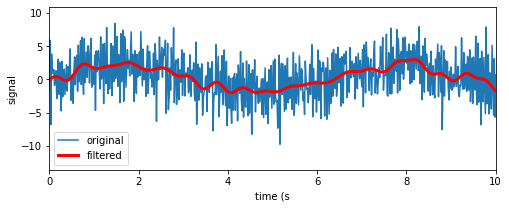

In [11]:
# 원래의 시간 영역 신호와 저주파-통과 필터를 적용한 주파수 도식화
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='original')
ax.plot(t, f_t_filtered.real, color = "red", lw=3, label='filtered')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s")
ax.set_ylabel("signal")
ax.legend()

### 윈도우
**윈도우 함수**: 신호가 곱해지면 크기를 조절해 샘플링 주기의 처음과 마지막 부분을 0에 가깝게 만드는 함수    
  
-> 샘플링 주기와 정확히 구분되지 않는 신호 구성 요소를 가진 신호를 DFT할 경우 발생하는 주파수 빈 사이의 스펙트럼 누출을 줄임  

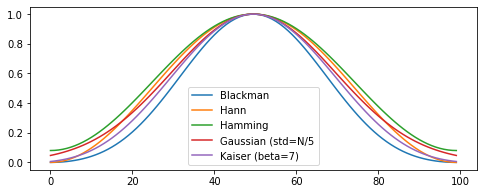

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")
ax.legend(loc=0)

In [13]:
df = pd.read_csv('temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])
df.time = (pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm'))
df = df.set_index("time")
df = df.resample("H").ffill()  # 시간격으로 재표본 후 요소 집계
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

In [14]:
time = df.index.astype('int64')/1.0e9  # 배열 추출
temperature = df.temperature.values

C:\Users\RENTAL~1\AppData\Local\Temp/ipykernel_10748/3216300336.py:1: FutureWarning: casting datetime64[ns, Europe/Stockholm] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  time = df.index.astype('int64')/1.0e9  # 배열 추출


In [15]:
window = signal.blackman(len(temperature))  # 블랙만 윈도우 함수 적용

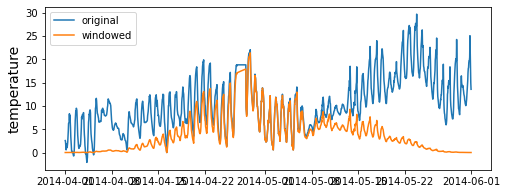

In [16]:
# 원래의 온도 시계열과 윈도우된 온도 시계열 비교
# -> 샘플링 주기 경계 부근에서 0에 근접하는 신호로 주기 경계 간 전환이 원활한 주기 함수
temperature_windowed = temperature * window
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original")
ax.plot(df.index, temperature_windowed, label="windowed")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

In [17]:
# 스펙트럼을 계산하고 각 주파수 빈에 해당하는 주파수 계산
data_fft_windowed = fftpack.fft(temperature_windowed)
f = fftpack.fftfreq(len(temperature), time[1]-time[0])

Text(0.5, 0, 'frequency (Hz)')

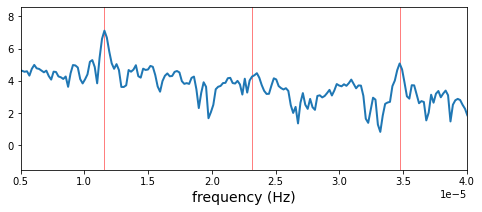

In [18]:
# 윈도우된 온도 시계열 스펙트럼
# -> 1일 주기에 해당하는 주파수의 피크와 상위 조화파 나타남
mask = f > 0
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0.000005, 0.00004)
ax.axvline(1./86400, color='r',lw=0.5)
ax.axvline(2./86400, color='r',lw=0.5)
ax.axvline(3./86400, color='r',lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])), lw=2)
ax.set_xlabel("$log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)

### 스펙트로그램
기타에서 표본 추출된 오디오 신호의 스펙트럼 분석

In [19]:
# 샘플링 속도와 오디오 강도 반환
sample_rate, data = io.wavfile.read("guitar.wav")

In [20]:
sample_rate

44100

In [21]:
data.shape

(1181625, 2)

In [22]:
data = data.mean(axis=1)  # 두 채널의 평균을 형성해 단일 채널 신호 생성

In [23]:
data.shape[0] / sample_rate  # 표본수 / 샘플링 속도 = 오디오 녹음의 총 지속시간

26.79421768707483

시간-영역 신호에서 움지기이는 윈도우에 FFT 적용 -> 시간에 종속된 스펙트럼(이퀄라이저 그래프로 시각화)  
2차원 히트맵 그래프를 사용해 시간-종속 스펙트럼을 시각화 -> **스펙트로그램**

In [24]:
# 샘플링 속도를 이용해 사용할 표본수 계산
N = int(sample_rate/2.0)  # 0.5초 --> 22050 표본

In [25]:
f = fftpack.fftfreq(N, 1.0/sample_rate)  # FFT를 통해 주파수 계산
t = np.linspace(0, 0.5, N)  # 시간-영역 신호의 표본 샘플링 시간 계산
mask = (f > 0) * (f < 1000)  # 1000Hz 미만 양의 주파수 마스크

In [26]:
subdata = data[:N]  # 전체 표본 배열 데이터에서 N개 표본 추출
F = fftpack.fft(subdata)

Text(0.5, 0, 'Frequency (Hz)')

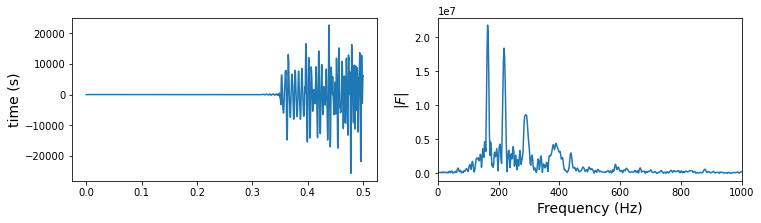

In [27]:
# 기타 소리의 0.5초 표본 신호의 스펙트럼
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_ylabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)

In [28]:
n_max = int(data.shape[0] / N)  # 표본 배열 데이터의 길이 N의 구역 수
f_values = np.sum(mask)  # 양의 주파수 1000Hz 미만인 주파수를 가진 주파수 빈의 개수
spectogram_data = np.zeros((n_max, f_values))  # 연속 표본 구간의 스펙트럼을 저장할 수 있는 배열

In [29]:
window = signal.blackman(len(subdata))  # 블랙만 윈도우 함수 적용

In [30]:
# 표본의 각 세그먼트에 대한 스펙트럼 계산 후 윈도우 함수를 적용해 FFT 계산
for n in range(0, n_max):
  subdata = data[(N * n):(N * (n + 1))]
  F = fftpack.fft(subdata * window)
  spectogram_data[n, :] = np.log(abs(F[mask]))

Text(0.5, 0, 'Frequency (Hz)')

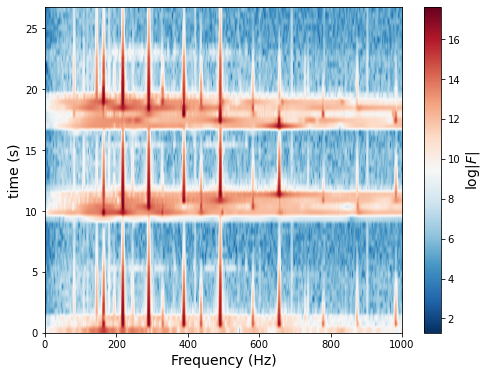

In [31]:
# 스펙트로그램 시각화
# -> 음색, 기타 줄이 튕겨지는 시간 주기, 색상 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spectogram_data, origin='lower', extent=(0, 1000, 0, data.shape[0] / sample_rate), aspect='auto', cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=14)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)

## 신호 필터

### 컨볼루션 필터
2개의 함수의 곱 푸리에 변환

In [32]:
# 필터 H의 줖수 응답 함수를 역푸리에 변환하고 결과 H를 커널로 사용해 원래 시간-영역 신호 f_t를 컨볼루션
t = np.linspace(0, T, N)
f_t = signal_samples(t)
H = abs(f) < 2
h = fftpack.fftshift(fftpack.ifft(H))
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

ValueError: x and y must have same first dimension, but have shapes (22050,) and (6000,)

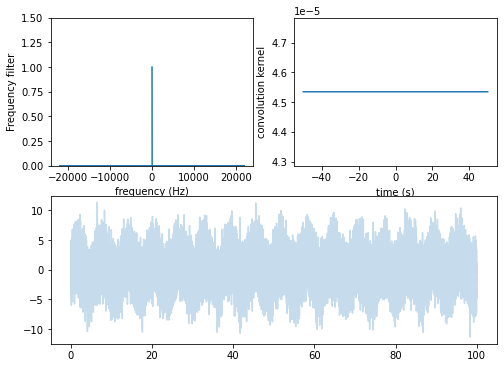

In [33]:
# 주파수 필터와 컨볼루션 커널 필터 비교
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)
ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - t[-1]/2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")
ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, 'r', lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

### FIR 및 IIR 필터
b_k와 a_k값의 유한 시퀀스를 안다면 시간 영역에서 순차적 계산 가능

In [34]:
# FIR 필터의 b_k 계수 계산
n = 101
f_s = 1 / 3600
nyq = f_s/2
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

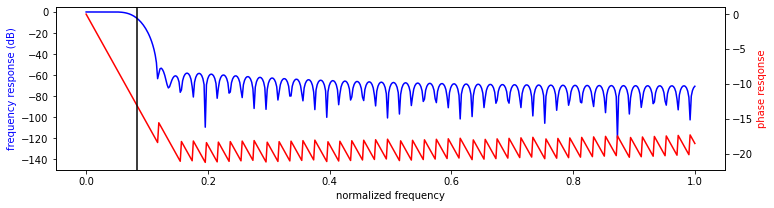

In [35]:
# 저주파 FIR 필터의 진폭과 위상 응답 계산 후 도식화
f, h = signal.freqz(b)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase resqonse', color="r")
ax.axvline(1.0/12, color='black')

In [36]:
# FIR 필터를 시간당 온도 측정 배열에 적용
temperature_filt = signal.lfilter(b, 1, temperature)

In [37]:
# 중앙값 필터 적용
temperature_median_filt = signal.medfilt(temperature, 25)

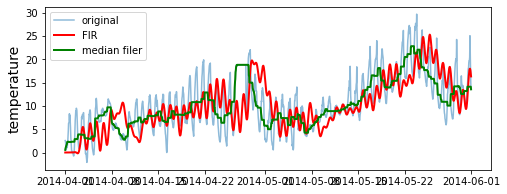

In [38]:
# FIR 필터와 중앙값 필터 적용 결과 도식화
# FIR 필터 -> 고주파 진동을 제거해 함수를 평활화, FIR 필터의 탭 수에 해당하는 시간 지연만큼 원래 신호에서 이동
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filt, color="red", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filt, color="green", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

In [39]:
# 버터 워스 고주파-통과 필터 생성 -> 저주파는 억제하면서 임계 주파수 7/365Hz 이상의 주파수는 통과시킴
b, a = signal.butter(2, 7/365.0, btype='high')

In [40]:
b

array([ 0.95829139, -1.91658277,  0.95829139])

In [41]:
a

array([ 1.        , -1.91484241,  0.91832314])

In [42]:
# IIR 필터를 시간당 온도 측정 배열에 적용
temperature_iir = signal.lfilter(b, a, temperature)

In [43]:
# 난캐주얼 필터 생성
temperature_filtfilt = signal.filtfilt(b, a, temperature)

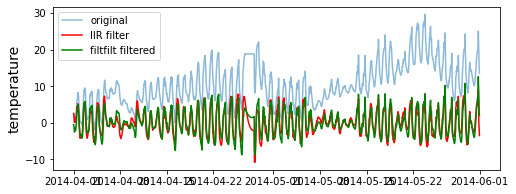

In [44]:
# IIR 고주파-통과 필터와 난캐주얼  필터 적용 결과 도식화
# IIR 필터 -> 저주파 성분을 제거하면 시계열을 추세가 감소하며 고주파수 진동과 파동만 유지
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtfilt, color="green", label="filtfilt filtered")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

In [45]:
# 과거 신호를 일정 시간 지연을 반복하는 FIR 필터 생성(에코 사운드 효과)
b = np.zeros(10000)
b[0] = b[-1] = 1
b /= b.sum()
data_filt = signal.lfilter(b, 1, data)

In [46]:
# wriite 함수를 사용해 WAV 파일로 저장
io.wavfile.write("guitar-echo.wav", sample_rate, np.vstack([data_filt, data_filt]).T.astype(np.int16))